In [1]:
import os
from os.path import join, splitext, basename, dirname, abspath
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline

In [2]:
from keras import initializations
from keras.optimizers import SGD, Adam

Using Theano backend.


In [2]:
import trading as trd
from trading import State, create_model, copy_model, track_model

Using Theano backend.


In [9]:
# relaod module after modifying it
import importlib
importlib.reload(trd)
importlib.reload(trd.stock_history)
importlib.reload(trd.portfolio)
importlib.reload(trd.benchmarks)
importlib.reload(trd.rl)
importlib.reload(trd)

<module 'trading' from 'C:\\Users\\hamza\\Documents\\school\\cs_229\\cs229_final_project\\src\\trading\\__init__.py'>

In [7]:
MODEL_DATA_LOC = '../data/model'

## Formulate Problem

In [3]:
# transaction cost to buy/sell a stock
trans_cost = 0.001
# starting cash
cash = 1e6
# starting portfolio allocation (%lo, %hi)
starting_weights = (0.5, 0.5)
# reward function (either Sharpe Ratio or last reward)
reward = trd.sharpe_ratio_reward

In [ ]:
# number of inputs
n = State.num_states()
# number of outputs
k = trd.actions.size
# total number of portfolios
M = 36
# size of training set
m = 27

In [12]:
# number of days input
d = 7
# pentalty on volatility
λ = 2

In [ ]:
# need to implement the above two

In [ ]:
error

## Data

In [5]:
train_data, test_data = trd.get_stock_pairs(m)

In [6]:
s = State(train_data[1], d=6, cash=cash, target_weights=starting_weights, trans_cost=trans_cost)

In [8]:
portfolio_states = [State(p, cash=cash, target_weights=starting_weights, trans_cost=trans_cost) for p in train_data]
# list to delete from, keep all the portfolio states in portfolio_states
#  generates a (shallow) copy rather than copy the list's reference 
available_states = portfolio_states[:]

## Hyperparameters

In [9]:
# size of experience replay
D = 6
# discount factor
γ = 0.99
# ϵ-greedy parameter
ϵ = 0.15
# hidden layer size
H = 100
# activation function
non_lin = 'relu'

# custom init
#  small starting seems to help
scale = 1E-4
def my_init(shape, name=None):
    return initializations.normal(shape, scale=scale, name=name)
#my_init = 'glorot_normal'

# alpha / learning rate
#α = 0.0001
# momentum in [0.5, 0.9, 0.95, 0.99]
#opt = SGD(lr=α, decay=1e-5, momentum=0.95, nesterov=True)
opt = Adam()

In [10]:
model = create_model(n=n, k=k, H=H, non_linearity=non_lin, init=my_init, optimizer=opt)

## Target Network

In [11]:
# target network drift
τ = 0.001

In [12]:
target = create_model(n=n, k=k, H=H, non_linearity=non_lin, init=my_init, optimizer=opt)

In [13]:
# start off with exact same init
copy_model(target, model)

## Start Training

In [14]:
# prints debugging info every so many iteration 
DEBUG = True
DEBUG_EVERY = 2500

In [15]:
train_record = pd.DataFrame(columns=('reward', 'loss'))
i = 0

In [16]:
#for _ in range(1):
while True:
    if available_states == []:
        # nothing left :(
        break
    # fill the experience replay
    elif len(available_states) < D:
        # getting close to the end
        exp_rep = np.random.permutation(available_states)
    else:
        exp_rep = np.random.choice(available_states, size=D, replace=False)

    # the actual size of the experience replay
    d = len(exp_rep)
    
    # actual state values of each portfolio
    states = np.array([st.state for st in exp_rep])
 
    qvalues = model.predict(states)

    # max_a w/ ϵ
    chosen_actions = trd.choose_actions(qvalues, ϵ)

    for (st, a) in zip(exp_rep, trd.actions[chosen_actions]):
        # execute the action
        st.execute_trade(a)

        # step forward to the next day
        try:
            st.step()
        except StopIteration:
            # reached end of data; no more stepping for this one
            available_states.remove(st)

    states_prime = np.array([st.state for st in exp_rep])
    rewards = np.array([reward(st) for st in  exp_rep])

    # max_a' Q(s', a')
    # use target network 
    qvalues_prime = np.max(target.predict(states_prime), axis=1)

    # the values we want (to minimize the MSE of)
    qvalues[np.arange(0,d), chosen_actions] = rewards + γ * qvalues_prime
    
    # train the network
    loss = model.train_on_batch(states, qvalues)
    loss = np.asscalar(loss[-1])
    
    # allow the target to drift behind
    track_model(target, model, τ)
    
    if np.isnan(loss) or (np.infty in qvalues) or (np.infty in qvalues_prime):
        # we hit the rails . . .
        # again
        break

    # append new value
    # not very efficient, but this probably not the slowest step
    train_record.loc[i,:] = [np.mean(rewards), loss]
    
    if (DEBUG) and (i % DEBUG_EVERY == 0):
        print('iter:  {:7d}\tloss:  {:<16g}'.format(i, loss))
        # print('reward: {:<+16g}'.format(np.mean(rewards)))
        # print('loss:   {:<16g}'.format(loss))
        
    i += 1


iter:        0	loss:  5.2374e-18      

iter:     2500	loss:  0.000222749     

iter:     5000	loss:  2.16577e-05     

iter:     7500	loss:  8.27221e-05     

iter:    10000	loss:  2.50785e-05     

iter:    12500	loss:  1.00497e-05     

iter:    15000	loss:  3.02259e-05     


## Testing

In [17]:
test_states = [State(p, cash=cash, target_weights=starting_weights, trans_cost=trans_cost) for p in test_data]
available_test_states = test_states[:]

In [18]:
while True:
    if available_test_states == []:
        break
    
    states = np.array([st.state for st in available_test_states])
 
    qvalues = model.predict(states)
    chosen_actions = np.argmax(qvalues, axis=1)
    
    for (st, a) in zip(available_test_states, trd.actions[chosen_actions]):
        # execute the action
        st.execute_trade(a)

        try:
            st.step()
        except StopIteration:
            available_test_states.remove(st)

In [46]:
MODEL_DIR = '{:d}h_{:s}_{:d}eps_{:d}init'.format(H, non_lin, int(ϵ*100), int(cash))
MODEL_DIR = join(MODEL_DATA_LOC, MODEL_DIR)
try:
    os.mkdir(MODEL_DIR)
except Exception:
    pass

In [48]:
model.save(join(MODEL_DIR, 'model.h5'))

In [47]:
for st in test_states:
    file_name = '{:s}_{:s}.csv'.format(st.lo.symbol, st.hi.symbol)
    st.portfolio.to_csv(join(MODEL_DIR, file_name))

In [9]:
def cust_plt(ax, data, label='', **kwargs):
    ax.plot_date(data.index, data, ls='solid', marker='', label=label, **kwargs)

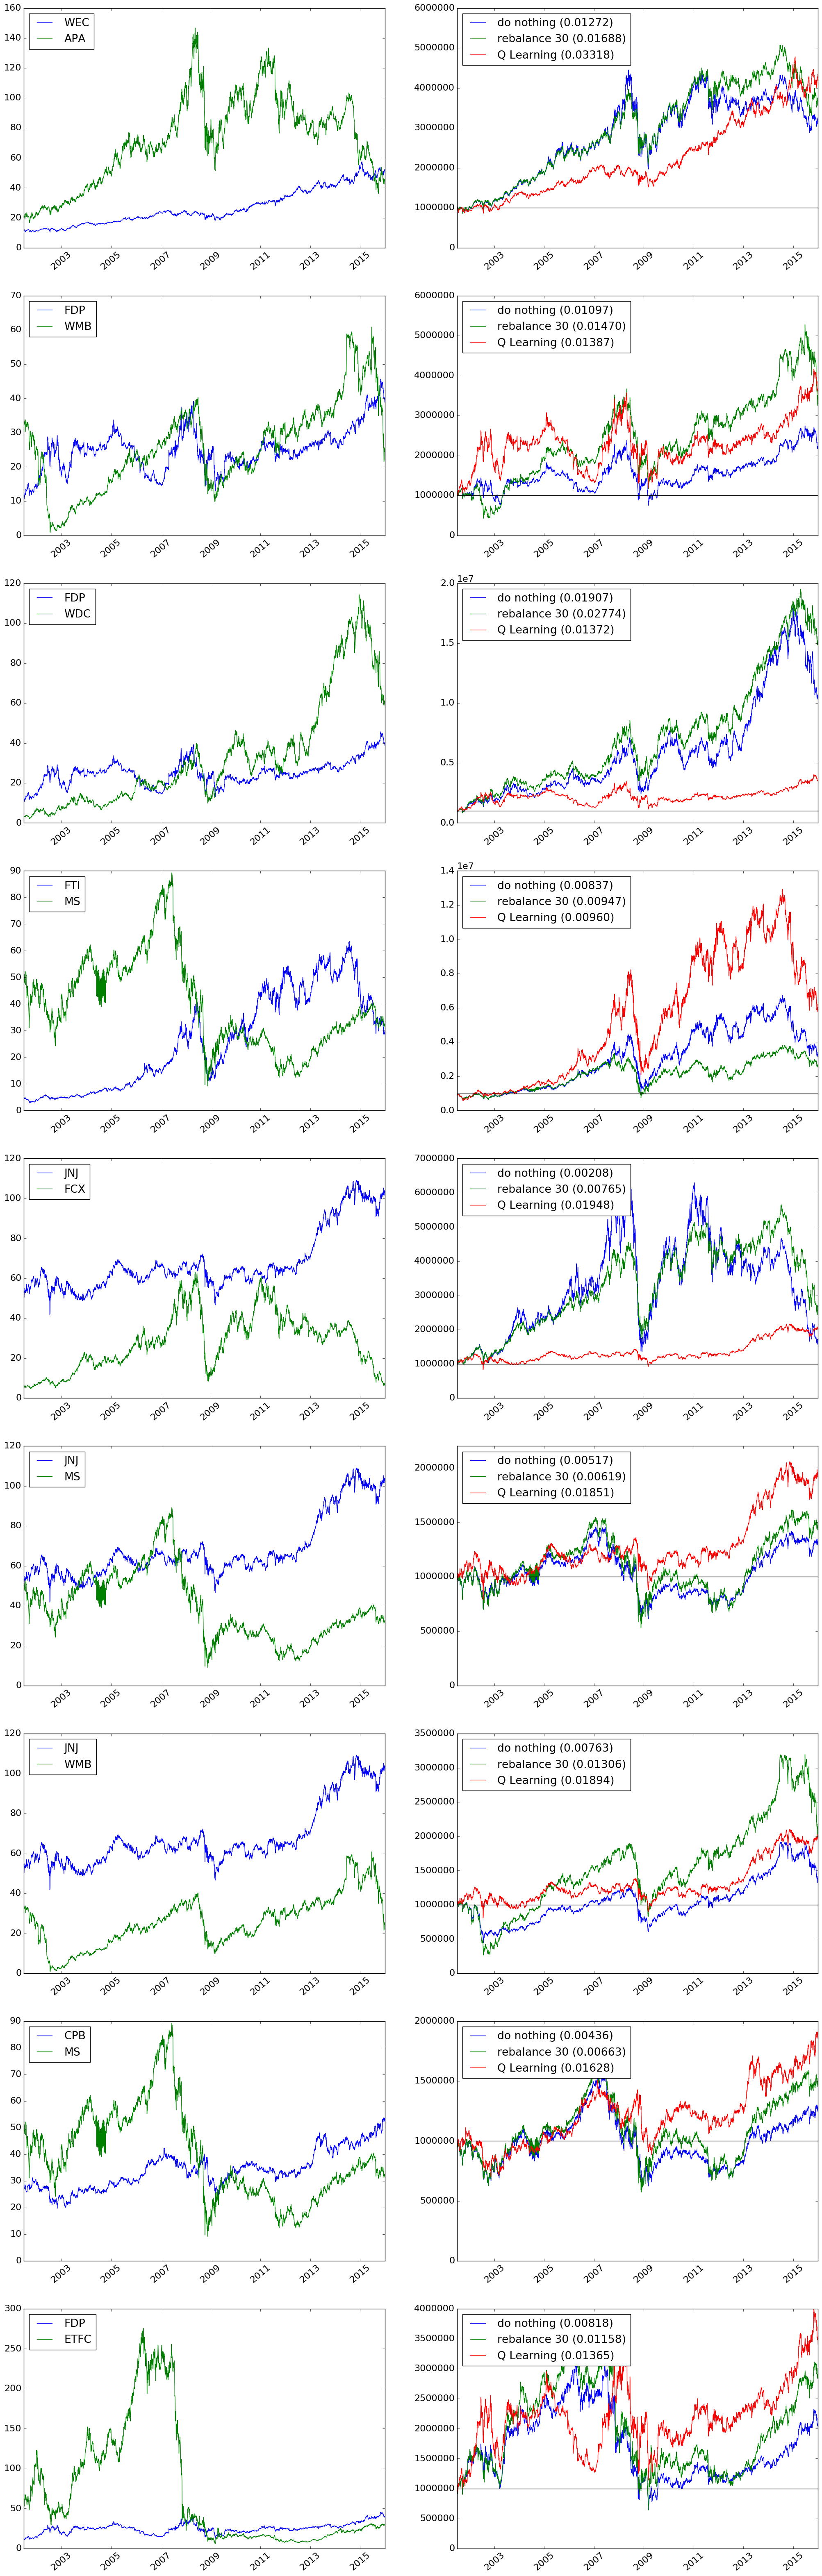

In [28]:
# number of test examples
N = M - m

matplotlib.rc('font', size=16)
f = plt.figure(figsize=(25, 80))

for i, st in enumerate(test_states):
    lo_name = st.lo.symbol
    hi_name = st.hi.symbol
    lo = st.portfolio.cost_lo
    hi = st.portfolio.cost_hi
    q = st.portfolio.total
    
    ax1 = plt.subplot(N, 2, 2*i + 1)
    cust_plt(ax1, lo, lo_name)
    cust_plt(ax1, hi, hi_name)
    ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.xticks(rotation=40)
    
    do_nothing = trd.do_nothing_benchmark(lo, hi, 
                                          trans_cost=trans_cost, 
                                          initial_value=cash)
    rebal = trd.rebalance_benchmark(lo, hi, rebalance_period=30, 
                                    initial_value=cash, 
                                    trans_cost=trans_cost)

    ax2 = plt.subplot(N, 2, 2*i + 2)
    lbl_str = '{:s} ({:.5f})'
    cust_plt(ax2, do_nothing.total, lbl_str.format('do nothing', reward(do_nothing)))
    cust_plt(ax2, rebal.total, lbl_str.format('rebalance 30', reward(rebal)))
    cust_plt(ax2, st.portfolio.total, lbl_str.format('Q Learning', reward(st.portfolio)))
    ax2.axhline(y=cash, color='black')
    ax2.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    ax2.set_ylim(bottom=0)
    plt.xticks(rotation=40)

In [27]:
f.savefig('nn_cmp.png')